In [1]:
%load_ext autoreload
%autoreload 2

## Oxygen in temperature space
Create some preliminary plots of the relationship between o2 and temp in ESM4

NOTES
- [ ] Select below the climatological winter mixed layer depth
- [x] Break it down by basin
- [x] Plot o2 saturation
- [ ] combine Indian Ocean basins
- [x] look at CM4
- [x] look at maps of o2 on temperature surfaces

Note that CM4 and ESM4 have different saved variables: only time-series data for CM4 o2, and no o2sat for CM4

In [2]:
import xarray as xr
from xhistogram.xarray import histogram
import numpy as np
import gfdl_utils as gu
import matplotlib.pyplot as plt
import os

In [3]:
config_id = 'ESM4_piControl_D'

if config_id == 'CM4_piControl_C':
    pathDict = {'pp':('/archive/oar.gfdl.cmip6/CM4/warsaw_201710_om4_v1.0.1/'+config_id+'/'+
                        'gfdl.ncrc4-intel16-prod-openmp/pp'),
                'out':'ts',
                'local':'annual/5yr',
                'time':'0396-0400'}
    pathDict['out']='ts'
    pathDict['local']='annual/5yr'
    pathDict['add']='o2'
    pathDict['ppname']='ocean_bling_cmip6_omip_tracers_year_z_1x1deg'
    path=gu.core.get_pathspp(**pathDict)
    gridpath=gu.core.get_pathstatic(pathDict['pp'],pathDict['ppname'])
    # gu.core.issue_dmget(path)
    # gu.core.issue_dmget(gridpath)
    ds_cobalt = gu.core.open_frompp(**pathDict).mean('time')
    ### Put in a dummy o2sat variable for now
    ds_cobalt['o2sat'] = xr.full_like(ds_cobalt['o2'],fill_value=np.nan)

    pathDict['out']='av'
    pathDict['local']='annual_5yr'
    pathDict['ppname']='ocean_annual_z_1x1deg'
    pathDict['add']='ann'
    path=gu.core.get_pathspp(**pathDict)
    gridpath=gu.core.get_pathstatic(pathDict['pp'],pathDict['ppname'])
    # gu.core.issue_dmget(path)
    # gu.core.issue_dmget(gridpath)
    ds_mom = gu.core.open_frompp(**pathDict)
    grid = xr.open_dataset(gridpath)

    ds = xr.merge([ds_mom['so'],
                   ds_mom['thetao'],
                   ds_mom['volcello'],
                   ds_cobalt['o2'],
                   ds_cobalt['o2sat']])
    
elif config_id == 'ESM4_piControl_D':
    pathDict = {'pp':('/archive/oar.gfdl.cmip6/ESM4/DECK/'+config_id+'/'+
                        'gfdl.ncrc4-intel16-prod-openmp/pp'),
                'out':'av',
                'local':'annual_5yr',
                'time':'0396-0400',
                'add':'ann'}
    pathDict['ppname']='ocean_cobalt_omip_tracers_year_z_1x1deg'
    path=gu.core.get_pathspp(**pathDict)
    gridpath=gu.core.get_pathstatic(pathDict['pp'],pathDict['ppname'])
    # gu.core.issue_dmget(path)
    # gu.core.issue_dmget(gridpath)
    ds_cobalt = gu.core.open_frompp(**pathDict)
    pathDict['ppname']='ocean_annual_z_1x1deg'
    path=gu.core.get_pathspp(**pathDict)
    gridpath=gu.core.get_pathstatic(pathDict['pp'],pathDict['ppname'])
    # gu.core.issue_dmget(path)
    # gu.core.issue_dmget(gridpath)
    ds_mom = gu.core.open_frompp(**pathDict)
    grid = xr.open_dataset(gridpath)

    ds = xr.merge([ds_mom['so'],
                   ds_mom['thetao'],
                   ds_mom['volcello'],
                   ds_cobalt['o2'],
                   ds_cobalt['o2sat']])
ds = ds.squeeze()

In [4]:
# Select Southern Ocean
SOlat = -30
ds = ds.where(grid['geolat']<=SOlat,drop=True)
grid = grid.where(grid['geolat']<=SOlat,drop=True)
# Select subsurface
# dsSO = dsSO.sel({'z_l':slice(200,7000)})

In [5]:
figsavedir = '../figures/'+config_id+'/SouthernOcean/'
if ~os.path.isdir(figsavedir):
    cmd=('mkdir -p %s' %figsavedir)
    os.system(cmd)

#### Zonal mean oxygen and temperature

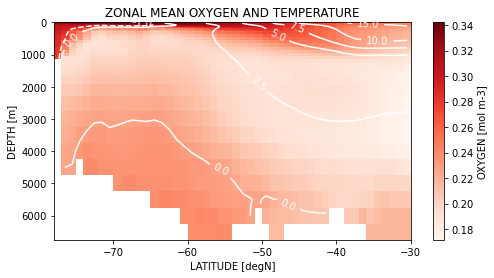

In [6]:
fig,ax = plt.subplots(figsize=(8,4))
im = ax.pcolormesh(ds['lat'],ds['z_l'],ds['o2'].mean('lon').squeeze(),cmap='Reds')
cb = plt.colorbar(im,ax=ax)
thetao_levs = [-1,0,2.5,5,7.5,10,15]
cs = ax.contour(ds['lat'],ds['z_l'],ds['thetao'].mean('lon').squeeze(),thetao_levs,colors='w')
ax.invert_yaxis()
ax.clabel(cs, thetao_levs, inline=True, fontsize=10)
ax.set_ylabel('DEPTH [m]')
ax.set_xlabel('LATITUDE [degN]')
cb.ax.set_ylabel('OXYGEN [mol m-3]')
ax.set_title('ZONAL MEAN OXYGEN AND TEMPERATURE')
fig.savefig(figsavedir+'o2-thetao.xmean.'+pathDict['time']+'.png',transparent=True,dpi=300)

#### Oxygen in temperature space

In [7]:
thetao_bins = np.arange(-2,20,0.5)
o2_bins = np.arange(0,0.5,0.01)
hs_to2 = xr.Dataset()
hs_to2['volcello'] = histogram(ds['thetao'],ds['o2'],
                             bins=[thetao_bins,o2_bins],
                             weights=ds['volcello'],
                             dim=['lat','lon','z_l'])
hs_to2 = hs_to2.squeeze()
# normalize in each temperature bin
hs_to2 = hs_to2/hs_to2.sum('o2_bin')

In [8]:
thetao_bins = np.arange(-2,20,0.5)
o2sat_bins = np.arange(0,0.5,0.01)
hs_to2s = xr.Dataset()
hs_to2s['volcello'] = histogram(ds['thetao'],ds['o2sat'],
                             bins=[thetao_bins,o2sat_bins],
                             weights=ds['volcello'],
                             dim=['lat','lon','z_l'])
hs_to2s = hs_to2s.squeeze()
# normalize in each temperature bin
hs_to2s = hs_to2s/hs_to2s.sum('o2sat_bin')

In [9]:
def calc_weightedstats_hs(hs,dim):
    array = hs[dim]*xr.ones_like(hs['volcello'])
    stats = xr.Dataset()
    stats['mean'] = array.weighted(hs['volcello'].fillna(0)).mean(dim)
    stats['std'] = array.weighted(hs['volcello'].fillna(0)).std(dim)
    return stats
    
def plot_hs_o2(ax,hs):
    hs = hs.squeeze()
    # stats
    stats = calc_weightedstats_hs(hs,'o2_bin')
    
    # plot
    im=ax.pcolormesh(hs['thetao_bin'],
                  hs['o2_bin'],
                  hs['volcello'].transpose(),
                  cmap='magma_r',
                  vmax=0.5)
    cb = plt.colorbar(im,ax=ax)
    ax.errorbar(stats['thetao_bin'],stats['mean'],yerr=stats['std'],
                linestyle='',
                marker='o',
                markerfacecolor='w',
                markeredgecolor='gray',
                ecolor='gray',
                alpha=0.5,
                label='Weighted-mean O2 in each temperature bin')
    ax.legend()
    ax.set_ylabel('OXYGEN [mol m-3]')
    ax.set_xlabel('TEMPERATURE [degC]')
    cb.ax.set_ylabel('FRACTION \n(in each temperature bin)');
    
def plot_hs_o2_o2sat(ax,hs_o2,hs_o2sat):
    # First plot o2
    plot_hs_o2(ax,hs_o2)
    # Add oxygen saturation
    stats_o2s = calc_weightedstats_hs(hs_to2s,'o2sat_bin')
    ax.plot(stats_o2s['thetao_bin'],stats_o2s['mean'],
            linestyle=':',
            color='tab:green',
            marker='.',
            markerfacecolor='w',
            markeredgecolor='tab:green',
            label='Weighted-mean O2sat')
    ax.legend()

#### TOTAL

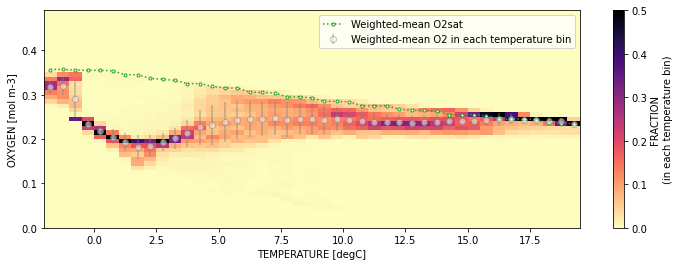

In [10]:
fig,ax = plt.subplots(figsize=(12,4))
plot_hs_o2_o2sat(ax,hs_to2,hs_to2s)
fig.savefig(figsavedir+'o2_in_thetao.histogram.'+pathDict['time']+'.png',transparent=True,dpi=300)

#### Basin break-down

In [11]:
lon_bins = np.array([-300,-230,-150,-70,20,50])
ds['geolon']=(grid*xr.ones_like(ds['o2']))['geolon']
hs_to2b = xr.Dataset()
hs_to2b['volcello'] = histogram(ds['thetao'],ds['o2'],ds['geolon'],
                             bins=[thetao_bins,o2_bins,lon_bins],
                             weights=ds['volcello'],
                             dim=['lat','lon','z_l'])
hs_to2b = hs_to2b.squeeze()
basins=['IndianEast','PacificWest','PacificEast','Atlantic','IndianWest']
hs_to2b = hs_to2b.rename({'geolon_bin':'basin'}).assign_coords({'basin':basins})
# normalize in each temperature bin
hs_to2b = hs_to2b/hs_to2b.sum('o2_bin')

In [12]:
# Oxygen saturation
lon_bins = np.array([-300,-230,-150,-70,20,50])
ds['geolon']=(grid*xr.ones_like(ds['o2sat']))['geolon']
hs_to2sb = xr.Dataset()
hs_to2sb['volcello'] = histogram(ds['thetao'],ds['o2sat'],ds['geolon'],
                             bins=[thetao_bins,o2sat_bins,lon_bins],
                             weights=ds['volcello'],
                             dim=['lat','lon','z_l'])
hs_to2sb = hs_to2sb.squeeze()
basins=['IndianEast','PacificWest','PacificEast','Atlantic','IndianWest']
hs_to2sb = hs_to2sb.rename({'geolon_bin':'basin'}).assign_coords({'basin':basins})
# normalize in each temperature bin
hs_to2sb = hs_to2sb/hs_to2sb.sum('o2sat_bin')

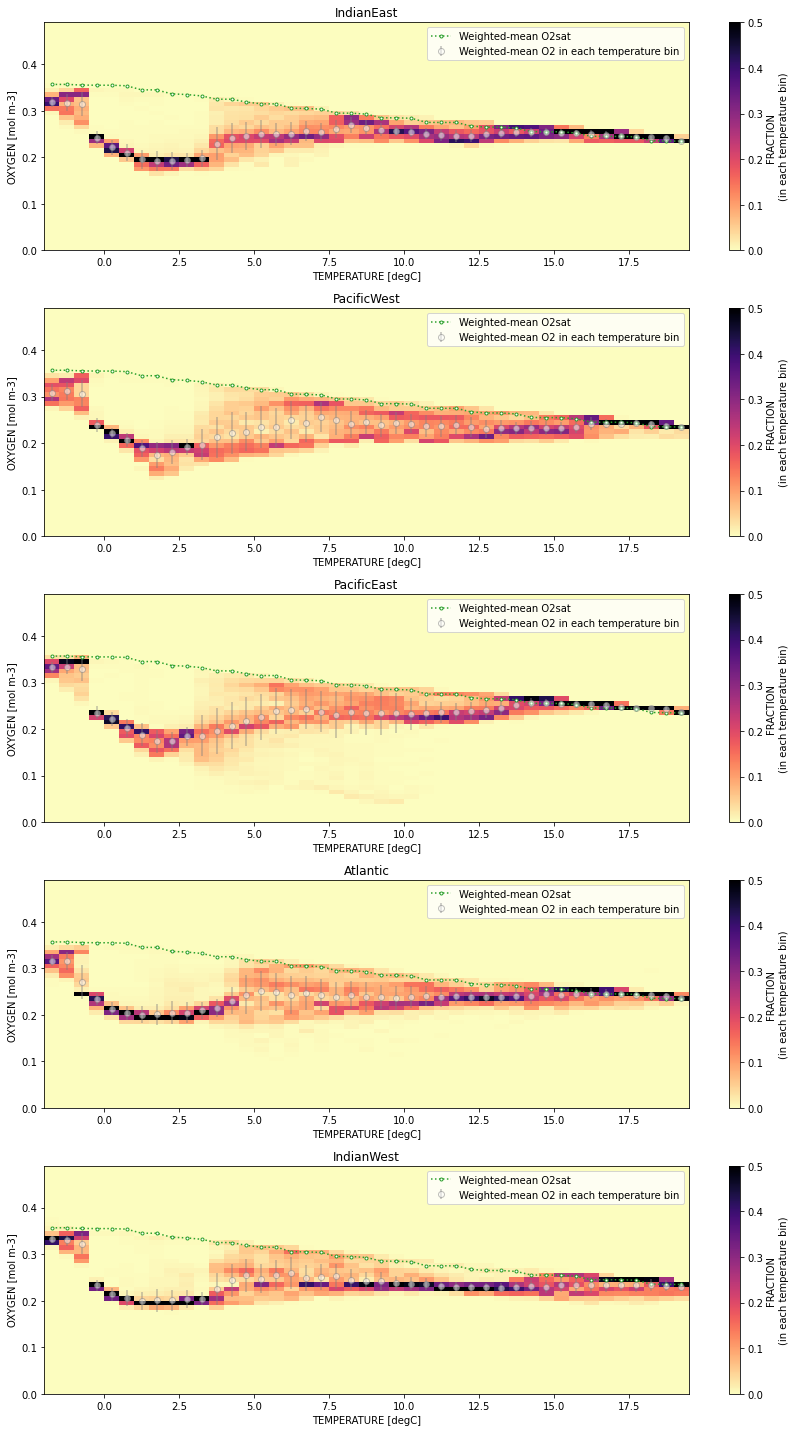

In [13]:
nb = len(hs_to2b['basin'])
fig,axarr = plt.subplots(figsize=(12,4*nb),nrows=nb)
for i,basin in enumerate(hs_to2b['basin']):
    ax = axarr.flat[i]
    plot_hs_o2_o2sat(ax,hs_to2b.sel({'basin':basin}),hs_to2sb.sel({'basin':basin}))
    ax.set_title(basin.values)
fig.tight_layout()
fig.savefig(figsavedir+'o2_in_thetao.histogram_bybasin.'+pathDict['time']+'.png',transparent=True,dpi=300)

### Visualize spatial distribution of oxygen in temperature space

In [14]:
from xgcm import Grid

In [15]:
# Build an xgcm grid object in vertical dimension
z_i = np.array([0])
for k in range(len(ds['z_l'])):
    dz = ds['z_l'][k]-z_i[-1]
    z_i = np.append(z_i,ds['z_l'][k]+dz)
ds['z_i'] = z_i
ds['dz'] = ds['z_l'].copy(data=ds['z_i'].diff('z_i'))

coords = {'Z':{'center':'z_l','outer':'z_i'}}
metrics = {'Z':['dz']}
xgrid = Grid(ds, coords=coords, metrics=metrics, periodic=False)

In [16]:
# Conservatively remap thetao and thicknesses
ds['thetao_i']=xgrid.interp(ds['thetao'],'Z',boundary='extend')
ds = ds.chunk({'z_i':-1})
ds_thetao = xr.Dataset()
ds_thetao['o2_dz'] = xgrid.transform(ds['o2']*ds['dz'],
                                        'Z',
                                        target=thetao_bins,
                                        target_data=ds['thetao_i'],
                                        method='conservative')
ds_thetao['o2sat_dz'] = xgrid.transform(ds['o2sat']*ds['dz'],
                                        'Z',
                                        target=thetao_bins,
                                        target_data=ds['thetao_i'],
                                        method='conservative')
ds_thetao['dz'] = xgrid.transform(ds['dz']*xr.ones_like(ds['o2']),
                                    'Z',
                                    target=thetao_bins,
                                    target_data=ds['thetao_i'],
                                    method='conservative')
ds_thetao = ds_thetao.squeeze()

/nbhome/gam/miniconda3/envs/om4labs/lib/python3.9/site-packages/xgcm/transform.py:235: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(
/nbhome/gam/miniconda3/envs/om4labs/lib/python3.9/site-packages/xgcm/transform.py:235: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(
/nbhome/gam/miniconda3/envs/om4labs/lib/python3.9/site-packages/xgcm/transform.py:235: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(


#### ZONAL MEANS

In [17]:
# Latitude-depth plot
def plot_xmean_theta(ax,ds_thetao):
    tmp = ds_thetao['o2_dz'].sum('lon')/ds_thetao['dz'].sum('lon')
    im = ax.pcolormesh(tmp['lat'],
                       tmp['thetao_i'],
                       tmp.transpose(),
                       shading='auto',
                       vmin=0,vmax=0.3,
                       cmap='Reds')
    cb = plt.colorbar(im,ax=ax)
    ax.set_xlabel('LATITUDE [degN]')
    ax.set_ylabel('TEMPERATURE [degC]')
    cb.ax.set_ylabel('OXYGEN [mol m-3]')
    ax.set_title('ZONAL MEAN OXGYEN IN TEMPERATURE-SPACE');

/nbhome/gam/miniconda3/envs/om4labs/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


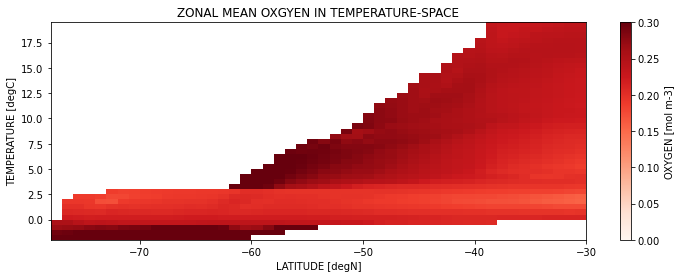

In [18]:
fig,ax = plt.subplots(figsize=(12,4))
plot_xmean_theta(ax,ds_thetao)
fig.savefig(figsavedir+'o2_in_thetao.xmean.'+pathDict['time']+'.png',transparent=True,dpi=300)

/nbhome/gam/miniconda3/envs/om4labs/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/nbhome/gam/miniconda3/envs/om4labs/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/nbhome/gam/miniconda3/envs/om4labs/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/nbhome/gam/miniconda3/envs/om4labs/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/nbhome/gam/miniconda3/envs/om4labs/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


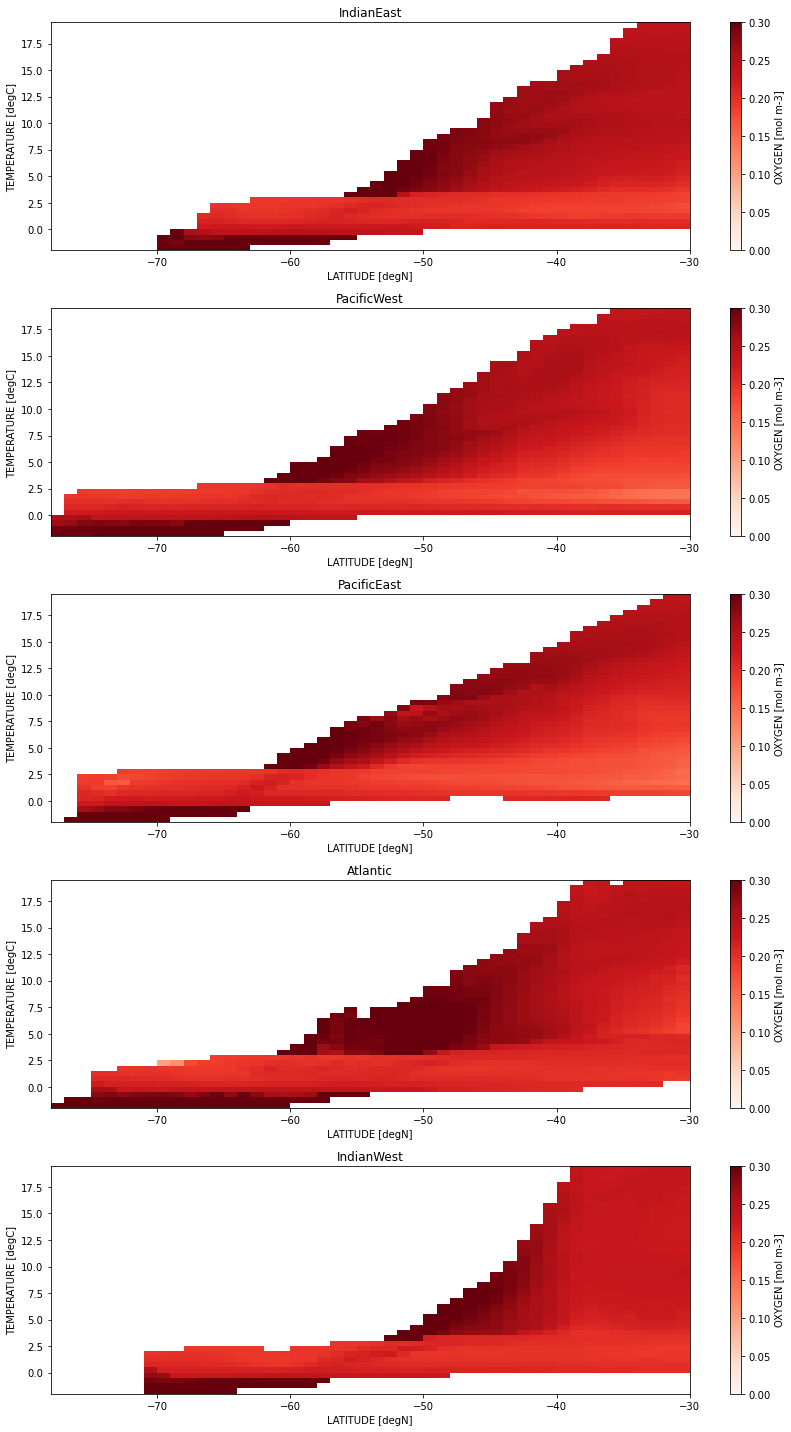

In [19]:
# Basins
nb = len(lon_bins)-1
fig,axarr = plt.subplots(figsize=(12,4*nb),nrows=nb)
for i in range(nb):
    ax = axarr.flat[i]
    cond = (grid['geolon']>=lon_bins[i]) & (grid['geolon']<lon_bins[i+1])
    ds_thetao_b = ds_thetao.where(cond,drop=True)
    plot_xmean_theta(ax,ds_thetao_b)
    ax.set_title(basins[i])
fig.tight_layout()
fig.savefig(figsavedir+'o2_in_thetao.xmean_bybasin.'+pathDict['time']+'.png',transparent=True,dpi=300)

#### MAPS

In [21]:
# Maps at certain temperature values
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=DeprecationWarning)
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
    from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

# import warnings
# warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 

In [22]:
def plot_map_on_theta(ax,ds_thetao,grid):
    
    ds_thetao['o2']=ds_thetao['o2_dz']/ds_thetao['dz']
    ds_thetao['o2sat']=ds_thetao['o2sat_dz']/ds_thetao['dz']
    ds_thetao['o2']=ds_thetao['o2'].where(ds_thetao['o2']>0,np.nan)
    ds_thetao['do2']=ds_thetao['o2']-ds_thetao['o2sat']

    im = ax.pcolormesh(grid['geolon'],
                       grid['geolat'],
                       ds_thetao['do2'].sel(thetao_i=thetao_i,method='nearest'),
                       transform=ccrs.PlateCarree(),
                       cmap='winter',
                       vmax=0,vmin=-0.2)
    ax.coastlines(resolution='110m',zorder=11)
    ax.add_feature(cfeature.LAND,zorder=10)
    ax.set_xticks([0, 60, 120, 180, 240, 300, 360], crs=ccrs.PlateCarree())
    ax.set_yticks([-60, -45], crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(number_format='.0f',
                                           degree_symbol='',
                                           dateline_direction_label=True)
    lat_formatter = LatitudeFormatter(number_format='.0f',
                                      degree_symbol='')
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    cb = plt.colorbar(im,ax=ax,fraction=0.01,pad=0.05)
    cb.ax.set_ylabel('O2 - O2sat [mol m-3]')

/nbhome/gam/miniconda3/envs/om4labs/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/nbhome/gam/miniconda3/envs/om4labs/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1702: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/nbhome/gam/miniconda3/envs/om4labs/lib/python3.9/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/nbhome/gam/miniconda3/envs/om4labs/lib/python3.9/site-packages/cartopy/

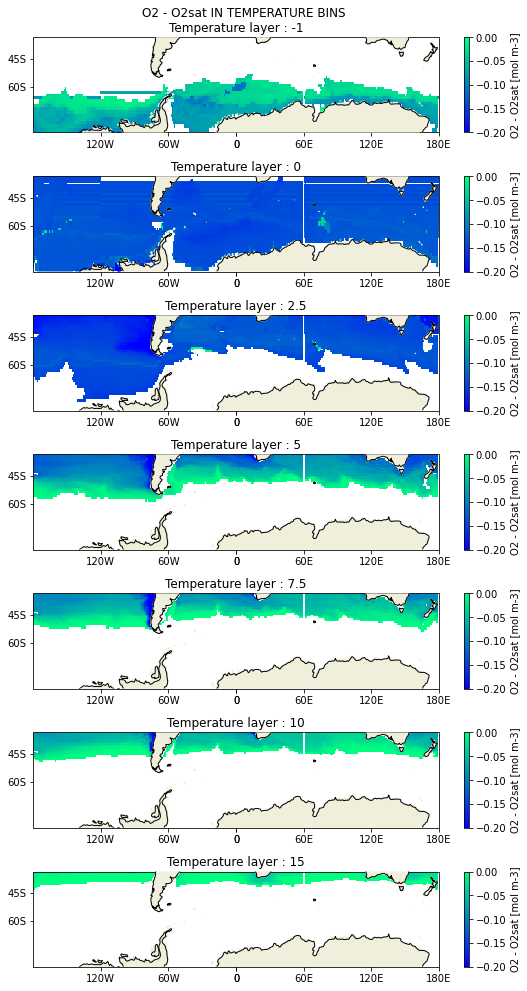

In [23]:
thetao_is = [-1,0,2.5,5,7.5,10,15]
nt = len(thetao_is)
fig,axarr = plt.subplots(figsize=(8,2*nt),
                         nrows=nt,
                         subplot_kw={'projection':ccrs.Mercator(min_latitude=-75.0)})
for i,thetao_i in enumerate(thetao_is):
    ax = axarr.flat[i]
    plot_map_on_theta(ax,ds_thetao,grid)
    ax.set_title('Temperature layer : %s' %thetao_i)
plt.suptitle('O2 - O2sat IN TEMPERATURE BINS')
fig.tight_layout()
fig.savefig(figsavedir+'o2_in_thetao.map_bylayer.'+pathDict['time']+'.png',transparent=True,dpi=300)

# ARCHIVE

In [94]:
thetao_bins = np.arange(-2,30,0.5)
hs = xr.Dataset()
hs['o2volcello'] = histogram(dsSO['thetao'],
                             bins=thetao_bins,
                             weights=dsSO['o2']*dsSO['volcello'],
                             dim=['lat','lon','z_l'])
hs['volcello'] = histogram(dsSO['thetao'],
                             bins=thetao_bins,
                             weights=dsSO['volcello'],
                             dim=['lat','lon','z_l'])
hs['o2'] = hs['o2volcello']/hs['volcello']
hs = hs.squeeze()

In [76]:
ds['o2']

<xarray.DataArray 'o2' (time: 1, z_l: 35, lat: 180, lon: 360)>
dask.array<open_dataset-185ccec6c31594300b6aab13bee8011co2, shape=(1, 35, 180, 360), dtype=float32, chunksize=(1, 35, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 0398-07-02 12:00:00
  * z_l      (z_l) float64 2.5 10.0 20.0 32.5 ... 5e+03 5.5e+03 6e+03 6.5e+03
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
Attributes:
    long_name:      Dissolved Oxygen Concentration
    units:          mol m-3
    cell_measures:  volume: volcello area: areacello
    standard_name:  mole_concentration_of_dissolved_molecular_oxygen_in_sea_w...
    interp_method:  conserve_order1
    cell_methods:   area:mean z_l:mean yh:mean xh:mean time: mean
    time_avg_info:  average_T1,average_T2,average_DT